# Kwalitatieve analyse

We gaan met behulp van Python en bijbehorende frameworks een kwalitatieve data analyse uitvoeren op de afgenomen diepteinterviews. Deze zijn getranscribeerd in Excel gezet. Deze tabel bestaat uit de interviewvragen, het bijbehorende antwoord en de naam van de respondent. Eerst uploaden we de transcripties met alle interviews.

In [1]:
from google.colab import files
uploaded = files.upload()

Saving transcripties_ruw.xlsx to transcripties_ruw.xlsx


Vervolgens gebruiken we het Pandas framework om het Excelbestand in een tabel te zetten: een zogeheten DataFrame. Dit DataFrame zal bestaan uit een kolom 'vraag', 'antwoord' en 'respondent'. We laten even als voorbeeld de eerste vijf rijen van het DataFrame zien.

In [2]:
import pandas as pd

interviews = pd.read_excel("transcripties_ruw.xlsx")
interviews.head()

,vraag,antwoord,respondent
0,"Ja, het gaat niet alleen over leegstand. Ik he...",Dan zou ik eerst naar de winkelhuurders gaan. ...,Marieke van Rooten
1,"Ja, het gaat niet alleen over leegstand. Ik he...","Maar het probleem is, wat hebben we in de wink...",Chris Westerman
2,Jullie vinden dat er niet genoeg oplossingen w...,"Ja, dat klopt. Het is alleen maar praten. Een ...",Jan Cozijnsen
3,Jullie vinden dat er niet genoeg oplossingen w...,De gemeente probeert dat wel. Ze hebben ons ve...,Mathias van Veen
4,Vinden jullie de leegstand merkbaar in Nijkerk?,"Ja, sommige winkels worden meer naar het centr...",Jan Cozijnsen


## Data ordening

We gaan werken met het **spaCy** taalverwerkingsalgoritme, wat goed werkt om NLP (Natural Language Processing) analyses uit te voeren op Nederlandse tekst.

In [3]:
!pip install spacy
!python -m spacy download nl_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 70.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('nl_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


Bij een kwalitatieve analyse helpen tokenisatie en POS-tagging (Part-of-Speech tagging) bij het beter begrijpen en structureren van de tekst.

- **Tokenisatie**: het proces van het splitsen van een tekst in kleinere eenheden, zoals woorden of zinnen. We gebruiken hierbij ook de *lemmatization* functionaliteit van spaCy, die woorden terugbrengt naar hun grondvorm.
- **POS tagging**: het proces waarbij elk woord in een tekst wordt gelabeld met de grammaticale functie, zoals zelfstandig naamwoord, werkwoord, bijvoeglijk naamwoord, etc. Klik [hier](https://universaldependencies.org/u/pos/all.html) voor de betekenis van deze labels.

In [4]:
import spacy

# Laad het Nederlandse taalmodel
nlp = spacy.load("nl_core_news_sm")

# Laad de stopwoordenlijst
stopwords = nlp.Defaults.stop_words

# Functie om tokens en POS-tags te verkrijgen en stopwoorden te filteren
def get_tokens_pos(text):
  doc = nlp(text)
  return [(token.lemma_, token.pos_) for token in doc if token.lemma_ not in stopwords and not token.is_punct]

interviews['token_pos_vraag'] = interviews['vraag'].apply(get_tokens_pos)
interviews['token_pos_antwoord'] = interviews['antwoord'].apply(get_tokens_pos)

Aan de hand van onze topiclijst kunnen we thema's gaan definiëren. Nu dat we woorden hebben omgezet naar hun grondvorm kunnen we een aantal sleutelwoorden opstellen die te maken hebben met onze thema's. Elk thema krijgt een nummer in het DataFrame.
1. Oplossingsgericht
2. Gemeente
3. Toekomstgericht
4. Publieksgericht
5. Constructief

In [5]:
thema_keywords = {
    '1': ['oplossing', 'achtergrond', 'voordelen', 'nadelen'],
    '2': ['gemeente', 'leegstand', 'nijkerk'],
    '3': ['toekomst', 'bijdrage', 'actie', 'handeling'],
    '4': ['betrokken', 'burger', 'publieksgericht'],
    '5': ['belangen', 'onderzoek']
}

# Thema toewijzen en tellen
def label_themes(row, thema_counters):
    thema_counts = {thema: 0 for thema in thema_keywords.keys()}
    tokens_vraag = [token for token, pos in row['token_pos_vraag']]
    tokens_antwoord = [token for token, pos in row['token_pos_antwoord']]

    for thema, keywords in thema_keywords.items():
        thema_counts[thema] += sum(token in keywords for token in tokens_vraag)
        thema_counts[thema] += sum(token in keywords for token in tokens_antwoord)

    # Selecteer het thema met de meeste matches
    max_thema = max(thema_counts, key=thema_counts.get)

    # Verhoog de teller voor het gekozen thema
    thema_counters[max_thema] += 1
    return f"{max_thema}.{thema_counters[max_thema]}"

thema_counters = {thema: 0 for thema in thema_keywords.keys()}

# Pas de label_themes functie toe
interviews['nummer'] = interviews.apply(label_themes, axis=1, thema_counters=thema_counters)
interviews.head()

,vraag,antwoord,respondent,token_pos_vraag,token_pos_antwoord,nummer
0,"Ja, het gaat niet alleen over leegstand. Ik he...",Dan zou ik eerst naar de winkelhuurders gaan. ...,Marieke van Rooten,"[(gaan, VERB), (leegstand, NOUN), (foto-report...","[(winkelhuurder, NOUN), (gaan, VERB), (problee...",2.1
1,"Ja, het gaat niet alleen over leegstand. Ik he...","Maar het probleem is, wat hebben we in de wink...",Chris Westerman,"[(gaan, VERB), (leegstand, NOUN), (foto-report...","[(probleem, NOUN), (winkel, NOUN), (Heeft, AUX...",2.2
2,Jullie vinden dat er niet genoeg oplossingen w...,"Ja, dat klopt. Het is alleen maar praten. Een ...",Jan Cozijnsen,"[(Jullie, PRON), (vinden, VERB), (genoeg, ADV)...","[(kloppen, VERB), (praten, VERB), (één, NUM), ...",1.1
3,Jullie vinden dat er niet genoeg oplossingen w...,De gemeente probeert dat wel. Ze hebben ons ve...,Mathias van Veen,"[(Jullie, PRON), (vinden, VERB), (genoeg, ADV)...","[(gemeente, NOUN), (proberen, VERB), (vertelle...",2.3
4,Vinden jullie de leegstand merkbaar in Nijkerk?,"Ja, sommige winkels worden meer naar het centr...",Jan Cozijnsen,"[(Vinden, VERB), (leegstand, NOUN), (merkbaar,...","[(sommig, DET), (winkel, NOUN), (centrum, NOUN...",2.4


## Labelingsproces
Op basis van veelvoorkomende woorden gaan we de fragmenten voorzien van labels. We kijken per antwoord welke tokens (zelfstandig naamwoorden of eigennaamen) het vaakst voorkomen. We gebruiken hierbij de tokens die het POS-tag 'NOUN' of 'PROPN' hebben, wat de grammaticale functie aangeeft. Op basis hiervan vullen we de nieuwe kolom 'label' op.

In [6]:
from collections import Counter

# Functie om de meest voorkomende tokens te verkrijgen
def get_most_common_token(token_pos_list, n=2):
    # Filter tokens gelabeld als zelfstandig naamwoord (NOUN) en eigennaam (PROPN)
    nouns_and_proper_nouns = [token for token, pos in token_pos_list if pos in ['NOUN', 'PROPN']]
    if nouns_and_proper_nouns:
        common_tokens = Counter(nouns_and_proper_nouns).most_common(n)
        common_tokens = [token for token, count in common_tokens]
        return "/".join(common_tokens)
    return ""

# Voeg de 'label' kolom toe aan het DataFrame, gebaseerd op het meest voorkomende token in 'token_pos_antwoord'
interviews['label'] = interviews['token_pos_antwoord'].apply(get_most_common_token)
interviews.head()

,vraag,antwoord,respondent,token_pos_vraag,token_pos_antwoord,nummer,label
0,"Ja, het gaat niet alleen over leegstand. Ik he...",Dan zou ik eerst naar de winkelhuurders gaan. ...,Marieke van Rooten,"[(gaan, VERB), (leegstand, NOUN), (foto-report...","[(winkelhuurder, NOUN), (gaan, VERB), (problee...",2.1,probleem/winkelhuurder
1,"Ja, het gaat niet alleen over leegstand. Ik he...","Maar het probleem is, wat hebben we in de wink...",Chris Westerman,"[(gaan, VERB), (leegstand, NOUN), (foto-report...","[(probleem, NOUN), (winkel, NOUN), (Heeft, AUX...",2.2,winkel/probleem
2,Jullie vinden dat er niet genoeg oplossingen w...,"Ja, dat klopt. Het is alleen maar praten. Een ...",Jan Cozijnsen,"[(Jullie, PRON), (vinden, VERB), (genoeg, ADV)...","[(kloppen, VERB), (praten, VERB), (één, NUM), ...",1.1,oplossing/winkel
3,Jullie vinden dat er niet genoeg oplossingen w...,De gemeente probeert dat wel. Ze hebben ons ve...,Mathias van Veen,"[(Jullie, PRON), (vinden, VERB), (genoeg, ADV)...","[(gemeente, NOUN), (proberen, VERB), (vertelle...",2.3,gemeente/winkel
4,Vinden jullie de leegstand merkbaar in Nijkerk?,"Ja, sommige winkels worden meer naar het centr...",Jan Cozijnsen,"[(Vinden, VERB), (leegstand, NOUN), (merkbaar,...","[(sommig, DET), (winkel, NOUN), (centrum, NOUN...",2.4,winkel/centrum


Om een idee te krijgen van welke onderwerpen het meest worden besproken, zullen we ook kijken naar de totale frequentie van woorden gelabeld als zelfstandig naamwoord en eigennaam.

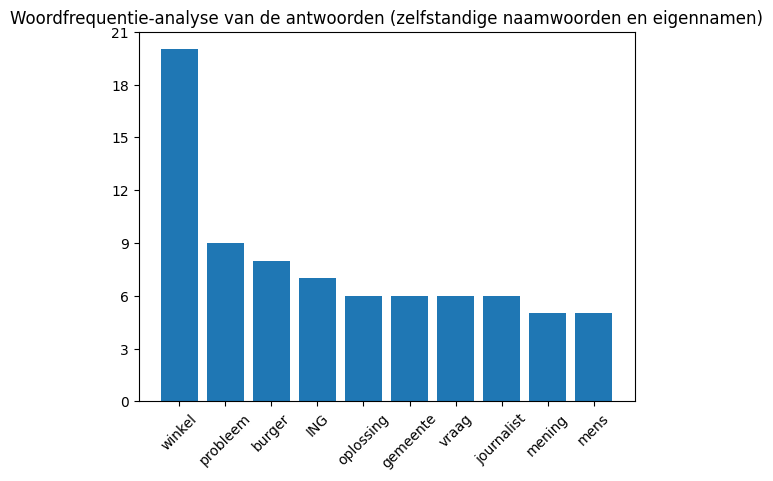

In [7]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def get_most_common_tokens(token_pos_list, n=10):
    # Filter de tokens met de POS-tag 'NOUN' en 'PROPN'
    nouns_and_proper_nouns = [token for sublist in token_pos_list for token, pos in sublist if pos in ['NOUN', 'PROPN']]
    return Counter(nouns_and_proper_nouns).most_common(n)

# Meest voorkomende tokens in antwoorden
most_common_tokens_antwoord = get_most_common_tokens(interviews['token_pos_antwoord'])

# Data voor de plot
tokens, counts = zip(*most_common_tokens_antwoord)

plt.bar(tokens, counts)
plt.xlabel('')
plt.ylabel('')
plt.title('Woordfrequentie-analyse van de antwoorden (zelfstandige naamwoorden en eigennamen)')
plt.xticks(rotation=45)
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

Vanwege de limitaties van spaCy zullen we handmatig het coderingsschema moeten nakijken. Ook kan het zijn dat er nog wat niet-relevante antwoorden in de tabel zitten of dat het verkeerd genummerd is. We zetten het DataFrame om naar een Excel bestand.

In [8]:
# Verwijder kolommen die niet meer nodig zijn
interviews_schema = interviews.drop(["token_pos_vraag", "token_pos_antwoord"], axis=1)

interviews_schema.to_excel("coderingsschema.xlsx", index=False)